## Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib  inline
sns.set(style='white', context='notebook', palette='deep') 
import joblib

# ML packages
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate,KFold

## Functions

In [2]:
def random_SCV(pipe = [], 
               grid_param = [],
               n_iter = 10, 
               cv = 5, 
               scoring = 'neg_mean_squared_error', 
               rnd_state = 42, 
               file_name = "",
              training = []):
    
    rnd_search = RandomizedSearchCV(pipe,param_distributions=grid_param, n_iter=n_iter, cv=cv, 
                                    scoring=scoring,
                                   verbose = 100000)
    rnd_search.fit(training[0],training[1])
    wr_pkl_file(file_name, rnd_search, False)
    

def grid_SCV(pipe = [], grid_param = [], cv = 5, scoring = 'neg_mean_squared_error', file_name = "", training = []):
    rnd_search = GridSearchCV(pipe, grid_param, cv=cv, scoring=scoring, verbose = 100)
    rnd_search.fit(training[0],training[1])
    wr_pkl_file(file_name, rnd_search, False)


def wr_pkl_file(file_name = "",content = "", read = False):
    if file_name:
        path_ = "./param_tuning/" + file_name
        if read:
            return joblib.load(path_)
             
        else:
            if content:
                joblib.dump(content, path_)
                
def print_results(labels = [], est = [], plt_num = 50, testing = []):
    col = 1
    plt.rcParams["figure.figsize"] = (30,15)
    for name, clf in zip(labels,est):
        print(name)
        
        df_labels_prediction = clf.predict(testing[0])
    
        print("R-Squared: {:.3f}".format(r2_score(np.exp(testing[1]), np.exp(df_labels_prediction))))
        mse = mean_squared_error(np.exp(testing[1]), np.exp(df_labels_prediction))
        mae = mean_absolute_error(np.exp(testing[1]), np.exp(df_labels_prediction))
        
        rmse = np.sqrt(mse)
        print("Root Mean Square Error: {:,.3f}".format(rmse))
        print("Mean Absolute Error: {:,.3f}".format(mae))
        print()

        plt.subplot(3,1,col)
        
        plt.title(name.replace(":",""), fontsize = 18)
        plt.xticks(fontsize = 18)
        plt.yticks(fontsize = 18)
        plt.plot(range(plt_num), np.exp(df_labels_prediction)[:plt_num], "*-", label='model prediction')
        plt.plot(range(plt_num), np.exp(testing[1])[:plt_num], "o--", label='true value')
        plt.legend()
        col += 1

def validation(models = [], estimators = [], training = [], cv = 5, train_score = False):
    if len(models) != len(estimators):
        print("Error: model names and estimator must have the same length")
        return

    for model, estimator in zip(models, estimators):
        scores = cross_validate(estimator, training[0], training[1], cv=cv,
                            scoring=('r2',
                                        'neg_mean_squared_error',
                                        'neg_mean_absolute_error'),
                            return_train_score=train_score)
        print(model)
        print("R-Squared: {:,.3f}".format(np.mean(scores["test_r2"])))
        print("Root Mean Squared Error: {:,.3f}".format(np.mean(np.sqrt(-scores["test_neg_mean_squared_error"]))))
        print("Mean Absolute Error: {:,.3f}".format(np.mean(-scores["test_neg_mean_absolute_error"])))
        print()


## Data Cleaning

In [3]:
# Reading csv
df = pd.read_csv("./data/nyc-rolling-sales.csv")

# Replacing missing values with NaN
df.replace(" -  ",np.nan, inplace = True)

# Dropping index and EASE-MENT
df.drop(['EASE-MENT',
         'Unnamed: 0',
         'APARTMENT NUMBER',
         'BUILDING CLASS AT TIME OF SALE'], axis=1, inplace=True)

# Convert str to float
floats = ['SALE PRICE', 'LAND SQUARE FEET', 'GROSS SQUARE FEET']

for col in floats:
    df[col]=pd.to_numeric(df[col], errors='coerce')
    
# Removing white spaces
df['BUILDING CLASS CATEGORY'] = df['BUILDING CLASS CATEGORY'].str.lstrip()
df['BUILDING CLASS CATEGORY'] = df['BUILDING CLASS CATEGORY'].str.rstrip()

# Categories we would like to focus on 
df1 = df.loc[df['BUILDING CLASS CATEGORY']=='01 ONE FAMILY DWELLINGS']
df2 = df.loc[df['BUILDING CLASS CATEGORY']=='02 TWO FAMILY DWELLINGS']
df3 = df.loc[df['BUILDING CLASS CATEGORY']=='13 CONDOS - ELEVATOR APARTMENTS']
df4 = df.loc[df['BUILDING CLASS CATEGORY']=='10 COOPS - ELEVATOR APARTMENTS']
df5 = df.loc[df['BUILDING CLASS CATEGORY']=='03 THREE FAMILY DWELLINGS']
df6 = df.loc[df['BUILDING CLASS CATEGORY']=='09 COOPS - WALKUP APARTMENTS']
df7 = df.loc[df['BUILDING CLASS CATEGORY']=='15 CONDOS - 2-10 UNIT RESIDENTIAL']
df8 = df.loc[df['BUILDING CLASS CATEGORY']=='07 RENTALS - WALKUP APARTMENTS']
df9 = df.loc[df['BUILDING CLASS CATEGORY']=='08 RENTALS - ELEVATOR APARTMENTS']
df10 = df.loc[df['BUILDING CLASS CATEGORY']=='06 TAX CLASS 1 - OTHER']
df11 = df.loc[df['BUILDING CLASS CATEGORY']=='41 TAX CLASS 4 - OTHER']
df12 = df.loc[df['BUILDING CLASS CATEGORY']=='04 TAX CLASS 1 CONDOS']

# Concat dataframes
applist = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12]
df = pd.concat(applist)

df = df[df['SALE PRICE'] > 5e5]
df = df[df['SALE PRICE'] < 5e6]

# # Residential units in range between 1 and 9 inclusive
df = df[df['RESIDENTIAL UNITS'] < 10]
df = df[df['RESIDENTIAL UNITS'] != 0]

# No commercial units
df = df[df['COMMERCIAL UNITS'] == 0]

# Drop unnecessary columns
df.drop(labels = ["COMMERCIAL UNITS","TOTAL UNITS"], axis = 1, inplace = True)


# Remove duplicates
print(df.shape)
df.drop_duplicates(inplace = True)
df.shape

# Remove NaN
df.dropna(inplace=True)


# Define costum label encoder (inline lambda function)
label_encoder = lambda x: {uniq : i for i,uniq in enumerate(df[x].unique().tolist())}


(24581, 16)


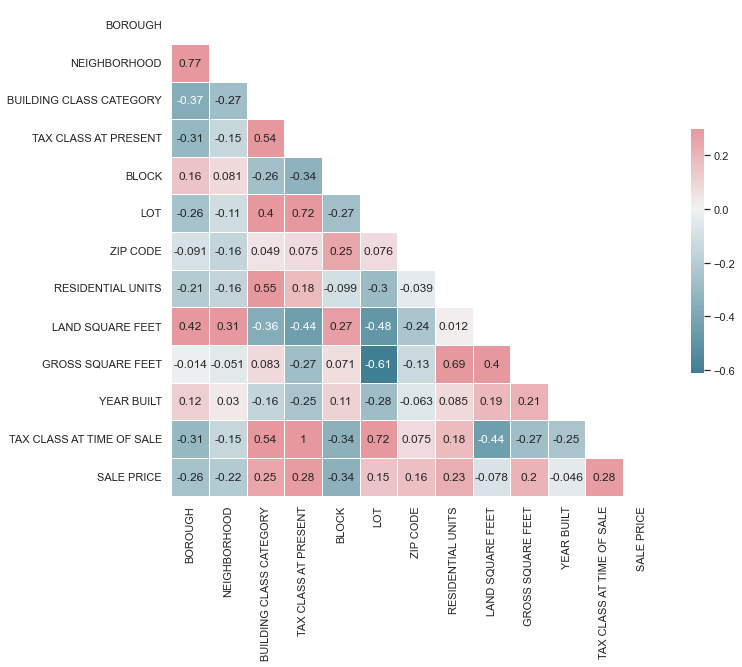

In [4]:
# New copy of dataframe
df_copy = df.copy()

df_copy["SALE PRICE"] = np.log(df_copy["SALE PRICE"])

# Map different columns to numbers
df_copy['NEIGHBORHOOD'] = df_copy['NEIGHBORHOOD'].map(label_encoder('NEIGHBORHOOD'))
df_copy['BUILDING CLASS CATEGORY'] = df_copy['BUILDING CLASS CATEGORY'].map(label_encoder('BUILDING CLASS CATEGORY'))
df_copy["TAX CLASS AT PRESENT"] = df_copy["TAX CLASS AT PRESENT"].map({'1': 1,'1A':1, '1B':1, '1C':1, 
                                                             '2':2, '2C':2, '2B':2, '2A':2,
                                                             '4':4})
# **** Code was taken from Jupiter Notebooks week 1 ******
sns.set(style="white")

# Spearman correlation
corr  = df_copy.corr(method = "pearson")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)


del df_copy


## Findings

1. Borough and Neighborhood are good predictors.

2. Building class category could be a strong predictors. 

3. Block, Residential units and Gross square feet are all good predictors

4. Tax Calss at Present could cause data leakage

# Handling Outliers

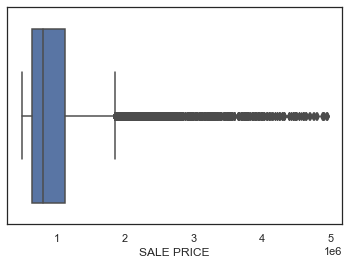

In [5]:
df_copy = df.copy()
sns.boxplot(df_copy["SALE PRICE"])
test = df_copy[df_copy["SALE PRICE"] > 1.4e6]


<AxesSubplot:>

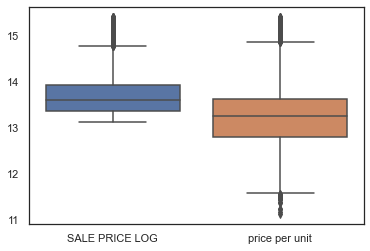

In [6]:


df_copy["price per unit"] = np.log(df_copy["SALE PRICE"] / df_copy["RESIDENTIAL UNITS"])
df_copy["SALE PRICE LOG"] = np.log(df_copy["SALE PRICE"])
sns.boxplot( data = df_copy[["SALE PRICE LOG", "price per unit"]])

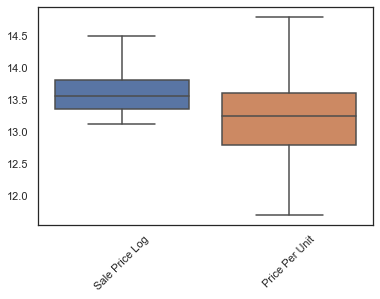

In [7]:
a = df_copy[df_copy["SALE PRICE LOG"] < 14.5]
b = df_copy[(df_copy["price per unit"] > 11.7) & (df_copy["price per unit"] < 14.8)]
ax = sns.boxplot(data = [a[["SALE PRICE LOG"]], b[["price per unit"]]])
ax.set_xticklabels(["Sale Price Log", "Price Per Unit"],rotation=45)
del a,b

In [8]:
print(len(df_copy))
print(len(df_copy[(df_copy["price per unit"] < 11.7) | (df_copy["price per unit"] > 14.8)]))
print(len(df_copy[df_copy["SALE PRICE LOG"] > 14.5]))
print(len(test))
# del df_copy

18423
286
1216
2709


# Machine Learning

## Preprocessing

In [9]:
def label_encode(column = ""):
    if column:
        df[column] = df[column].map(label_encoder(column))

# Label Encoder for neighborhood and Building class categroy
label_encode("NEIGHBORHOOD")
label_encode("BUILDING CLASS CATEGORY")

# DataFrame for Linear Regression (remove outliers)
lr_df = df.copy()

# Log sale price
df["SALE PRICE"] = np.log(df["SALE PRICE"])

# Chosen features for ML models
modified_df = df[["BOROUGH",
                  "NEIGHBORHOOD",
                  "BLOCK",
                  "LOT",
                  "BUILDING CLASS CATEGORY",
                  "RESIDENTIAL UNITS",
                  "GROSS SQUARE FEET",
                  ]]

y = df["SALE PRICE"]

# Split to train and test
tr_x_train, tr_x_test, tr_y_train, tr_y_test = train_test_split(modified_df,y, test_size=0.2, random_state=42)


# Handling outliers for Linear Regression

# Calculate price per unit and transform to log
lr_df["price per unit"] = np.log(lr_df["SALE PRICE"] / lr_df["RESIDENTIAL UNITS"])

# Remove outliers 
lr_df = lr_df[(lr_df["price per unit"] > 11.7) & (lr_df["price per unit"] < 14.8)]

lr_modified = lr_df[["BOROUGH",
                  "NEIGHBORHOOD",
                  "BLOCK",
                  "LOT",
                  "BUILDING CLASS CATEGORY",
                  "RESIDENTIAL UNITS",
                  "GROSS SQUARE FEET",
                  "price per unit",
                  "SALE PRICE"]]

# Split to train and test
train_set, test_set = train_test_split(lr_modified, test_size=0.2, random_state=42)

# Split data and target in training set
lr_y_train_ppu = train_set["price per unit"].copy()
lr_y_train_ru = train_set["RESIDENTIAL UNITS"].copy() # For cross validation
lr_y_train = train_set["SALE PRICE"].copy()           # For cross validation
lr_x_train_ppu = train_set.drop(["SALE PRICE","price per unit","RESIDENTIAL UNITS"], axis = 1)

# Split data and target in test set
lr_y_test_ppu = test_set["price per unit"].copy()
lr_y_test = test_set["SALE PRICE"].copy()
lr_y_test_ru = test_set["RESIDENTIAL UNITS"]
lr_x_test_ppu = test_set.drop(["SALE PRICE","price per unit","RESIDENTIAL UNITS"], axis = 1)

## Dummy Regressor

In [10]:
## Trees
print("Trees df")

# Initialize Dummy estimator 
dummy_regr = DummyRegressor(strategy="median")

# Train estimator
dummy_regr.fit(tr_x_train, tr_y_train)

# Predict 
preds = np.exp(dummy_regr.predict(tr_x_test))


# Calculate RMSE
mse = mean_squared_error(np.exp(tr_y_test), preds)
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(np.exp(tr_y_test), preds)

# Print results
print("R-Squared: {:,.3f}".format(r2_score(np.exp(tr_y_test), preds)))
print("Root Mean Square Error: {:,.3f}".format(rmse))
print("Mean Absolute Error: {:,.3f}".format(mae))
print()


## Linear Regression
print("Linear Regression df")

# Initialize Dummy estimator 
lr_dummy_regr = DummyRegressor(strategy="median")

# Train estimator
lr_dummy_regr.fit(lr_x_train_ppu, lr_y_train_ppu)

# Predict 
lr_preds = np.exp(lr_dummy_regr.predict(lr_x_test_ppu))

# Calculate RMSE
mse = mean_squared_error(np.exp(lr_y_test_ppu) * lr_y_test_ru, lr_preds * lr_y_test_ru)
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(np.exp(lr_y_test_ppu)* lr_y_test_ru, lr_preds * lr_y_test_ru)

# Print results
print("R-Squared: {:,.3f}".format(r2_score(np.exp(lr_y_test_ppu) * lr_y_test_ru, lr_preds * lr_y_test_ru)))
print("Root Mean Square Error: {:,.3f}".format(rmse))
print("Mean Absolute Error: {:,.3f}".format(mae))
print()

Trees df
R-Squared: -0.107
Root Mean Square Error: 602,116.561
Mean Absolute Error: 346,494.955

Linear Regression df
R-Squared: -0.695
Root Mean Square Error: 680,709.220
Mean Absolute Error: 475,646.653



## Pipeline

In [11]:
# Pipeline
numeric_features = ['GROSS SQUARE FEET',"BLOCK","LOT", "NEIGHBORHOOD"]
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())])


ohe_features = ["BUILDING CLASS CATEGORY", "BOROUGH"]
ohe_transformer = OneHotEncoder(sparse = False, handle_unknown = 'ignore')


preprocessor = ColumnTransformer(
    transformers=[
        ('scale', numeric_transformer, numeric_features),
        ('ohe', ohe_transformer, ohe_features),
        ])

## ML Estimators

In [12]:
# Linear regression Estimator
lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regression', LinearRegression())])

# Decision Tree Regressor
dtr = Pipeline(steps=[
                      ('dtr', DecisionTreeRegressor())])

# Extra Tree Regressor
etr = Pipeline(steps=[
                      ('etr', BaggingRegressor(ExtraTreeRegressor(random_state=42),
                                                        random_state = 42))])
# Random Forest Regressor
rfrr = Pipeline(steps=[
                      ('rfregression', RandomForestRegressor(random_state = 42, 
                                                             n_jobs= -1, 
                                                             n_estimators = 50, 
                                                             min_samples_leaf = 5))])


## Cross Validation 

### Linear Regression

In [13]:
# initialize the model
kf = KFold(n_splits=10, random_state = 42, shuffle = True)

# make a list to store our RMSE 
lr_RMSEs, lr_R2, lr_MAE = [], [], []

# loop over the k folds
for train_index, validate_index in kf.split(lr_x_train_ppu):
    
    # train the model using the training set
    lr.fit(lr_x_train_ppu.iloc[train_index,], lr_y_train_ppu.iloc[train_index,])
    
    # predict on a the validation set
    predictions = lr.predict(lr_x_train_ppu.iloc[validate_index,])
    predictions = np.exp(predictions) * lr_y_train_ru.iloc[validate_index,]

    test_set = lr_y_train.iloc[validate_index]

    # Append scores
    lr_R2.append(r2_score(test_set, predictions))
    
    mse = mean_squared_error(test_set,predictions)
    lr_RMSEs.append(np.sqrt(mse))
    
    lr_MAE.append(mean_absolute_error(test_set, predictions))
    

    
# let's look at the output from k fold
print("Linear Regression: ")
print("R-Squared: {:,.3f}".format(np.mean(lr_R2)))
print("Root Mean Squared Error: {:,.3f}".format(np.mean(lr_RMSEs)))
print("Mean Absolute Error: {:,.3f}".format(np.mean(lr_MAE)))
print()

Linear Regression: 
R-Squared: 0.252
Root Mean Squared Error: 445,688.977
Mean Absolute Error: 262,219.829



### Trees model

In [14]:
validation(models = ["Decision Tree Regressor", "Extra Tree Regressor", "Random Forest"], 
           estimators = [dtr, etr, rfrr],
           training = [tr_x_train, np.exp(tr_y_train)])

Decision Tree Regressor
R-Squared: 0.387
Root Mean Squared Error: 468,688.029
Mean Absolute Error: 263,499.225

Extra Tree Regressor
R-Squared: 0.634
Root Mean Squared Error: 362,108.704
Mean Absolute Error: 211,420.464

Random Forest
R-Squared: 0.649
Root Mean Squared Error: 354,854.906
Mean Absolute Error: 206,175.619



## Fit models

In [15]:
# Train Trees
dtr.fit(tr_x_train, tr_y_train)
etr.fit(tr_x_train, tr_y_train) 
rfrr.fit(tr_x_train, tr_y_train)

Pipeline(steps=[('rfregression',
                 RandomForestRegressor(min_samples_leaf=5, n_estimators=50,
                                       n_jobs=-1, random_state=42))])

In [16]:
# Train Linear Regression
lr.fit(lr_x_train_ppu, lr_y_train_ppu) 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scale',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['GROSS SQUARE FEET', 'BLOCK',
                                                   'LOT', 'NEIGHBORHOOD']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['BUILDING CLASS CATEGORY',
                                                   'BOROUGH'])])),
                ('regression', LinearRegression())])

## Testing

Descision Tree:
R-Squared: 0.404
Root Mean Square Error: 441,899.240
Mean Absolute Error: 250,540.002

Extra-Tree Regressor:
R-Squared: 0.652
Root Mean Square Error: 337,775.405
Mean Absolute Error: 194,745.277

Random Forest:
R-Squared: 0.650
Root Mean Square Error: 338,407.994
Mean Absolute Error: 190,655.493



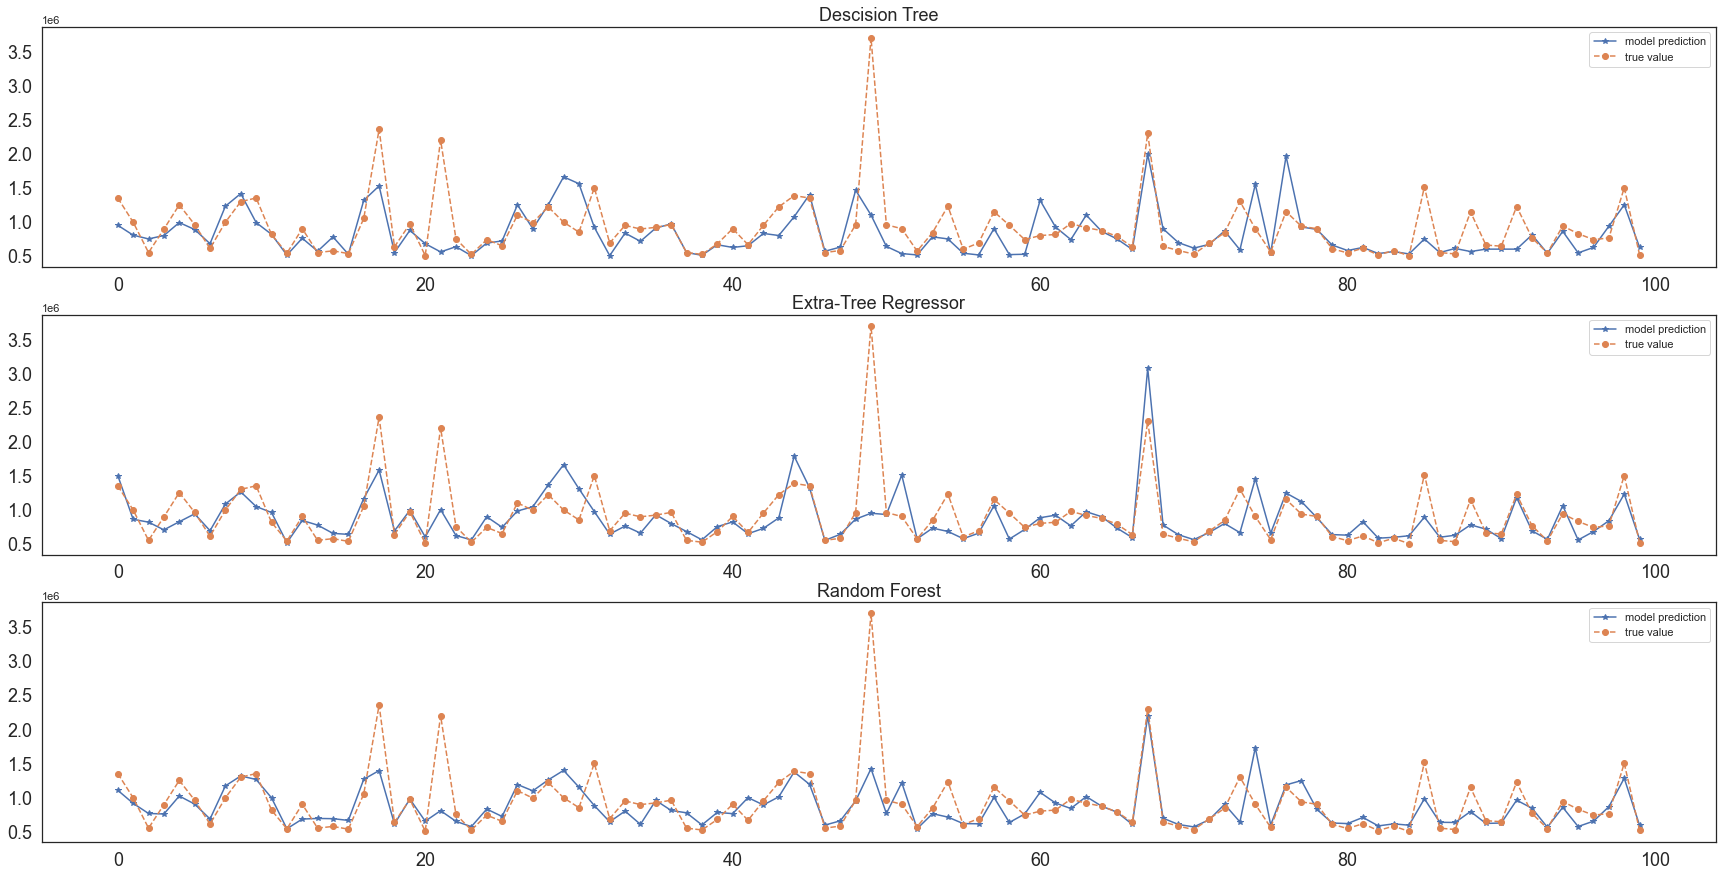

In [17]:
print_results(labels = ["Descision Tree:", "Extra-Tree Regressor:", "Random Forest:"],
             est = [dtr,etr, rfrr],
             plt_num = 100,
             testing = [tr_x_test, tr_y_test])

Linear Regression: 
R-Squared: 0.327
Root Mean Square Error: 428,974.407
Mean Absolute Error: 259,014.542



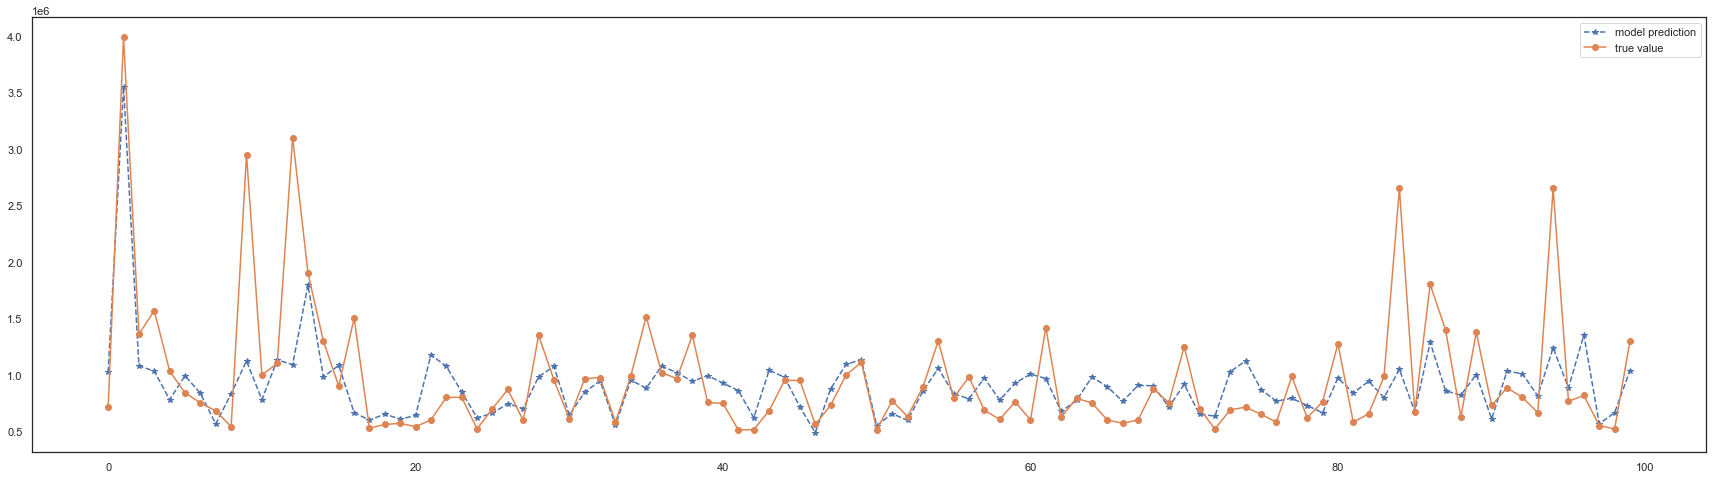

In [18]:
print("Linear Regression: ")

df_labels_prediction = lr.predict(lr_x_test_ppu)
df_labels_prediction =  np.exp(df_labels_prediction) * lr_y_test_ru

print("R-Squared: {:.3f}".format(r2_score(lr_y_test, df_labels_prediction)))
mse = mean_squared_error(lr_y_test,df_labels_prediction) 
mae = mean_absolute_error(lr_y_test, df_labels_prediction)

rmse = np.sqrt(mse)
print("Root Mean Square Error: {:,.3f}".format(rmse))
print("Mean Absolute Error: {:,.3f}".format(mae))
print()

plt.rcParams["figure.figsize"] = (30,8)
plt.plot(range(100), df_labels_prediction[:100],"*--" ,label='model prediction')
plt.plot(range(100), lr_y_test[:100],"o-", label='true value')
plt.legend()

## Hyperparameter Tuning

In [19]:
# ## Random Search CV
# grid_param = [{"etr__n_estimators": randint(low=20, high=60),
#                "etr__max_features":randint(low=1, high=6)}]


# random_SCV(etr,grid_param,n_iter = 5,cv = 10, file_name = "etr_test_1.pkl", training = [tr_x_train, tr_y_train])


test1
R-Squared: 0.673
Root Mean Square Error: 327,489.884
Mean Absolute Error: 186,690.905



Pipeline(steps=[('etr',
                 BaggingRegressor(base_estimator=ExtraTreeRegressor(random_state=42),
                                  max_features=5, n_estimators=40,
                                  random_state=42))])

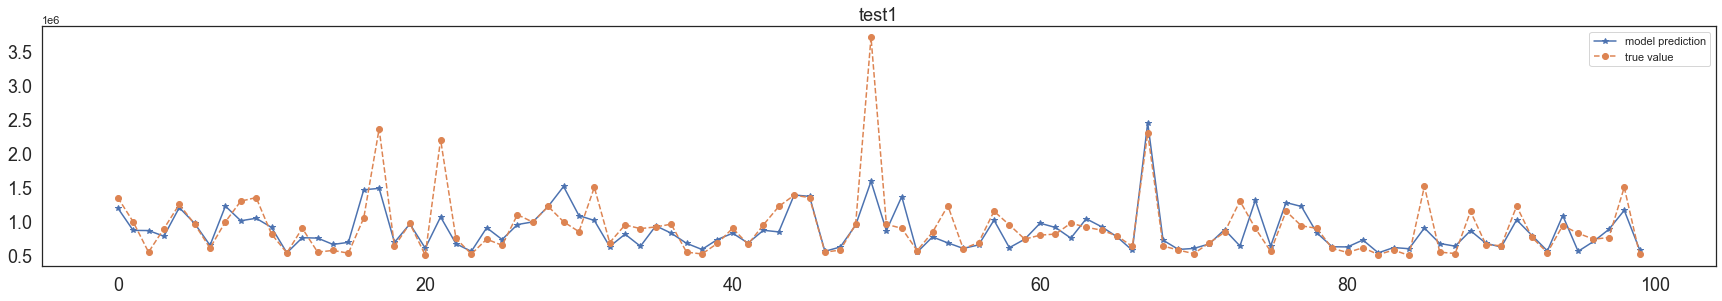

In [20]:
results = wr_pkl_file(file_name = "etr_test_1.pkl", read = True)
best_estimator = results.best_estimator_
# predictions = best_estimator.predict(x_test)
print_results(["test1"], best_estimator, testing = [tr_x_test, tr_y_test], plt_num = 100)
best_estimator

In [21]:
# ## Random Search CV
# grid_param = [{"dtr__max_depth": randint(low=20, high=60),
#                "dtr__min_samples_split":randint(low=2, high=6),
#                "dtr__min_samples_leaf": randint(low = 2, high = 10)}]


# random_SCV(dtr,grid_param,n_iter = 5,cv = 10, file_name = "dt_test_1.pkl", training = [tr_x_train, tr_y_train])


Decision Tree Random Search CV
R-Squared: 0.583
Root Mean Square Error: 369,410.920
Mean Absolute Error: 212,902.102



Pipeline(steps=[('dtr',
                 DecisionTreeRegressor(max_depth=35, min_samples_leaf=9,
                                       min_samples_split=5))])

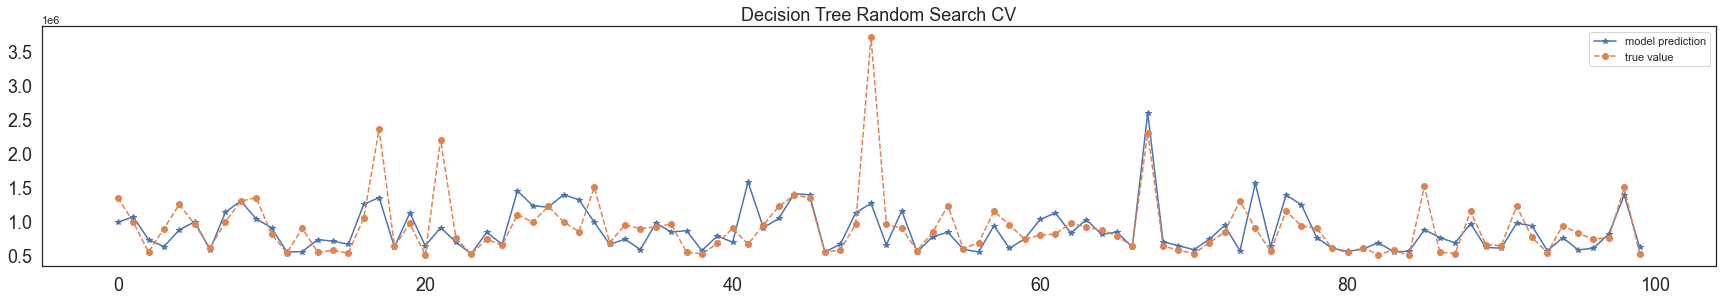

In [22]:
results = wr_pkl_file(file_name = "dt_test_1.pkl", read = True)
best_estimator = results.best_estimator_
# predictions = best_estimator.predict(x_test)
print_results(["Decision Tree Random Search CV"], best_estimator, testing = [tr_x_test, tr_y_test], plt_num = 100)
best_estimator

In [23]:
## Random Search CV

# grid_param = [{"rfregression__n_estimators": randint(low=20, high=100),
#                "rfregression__min_samples_leaf":randint(low=2, high=30)}]


# random_SCV(rfrr,grid_param,n_iter = 5,cv = 10, file_name = "rfr_test_2.pkl", training = [tr_x_train, tr_y_train])


Random Forest Random Search CV
R-Squared: 0.660
Root Mean Square Error: 333,608.167
Mean Absolute Error: 187,708.521



Pipeline(steps=[('rfregression',
                 RandomForestRegressor(min_samples_leaf=3, n_estimators=75,
                                       n_jobs=-1, random_state=42))])

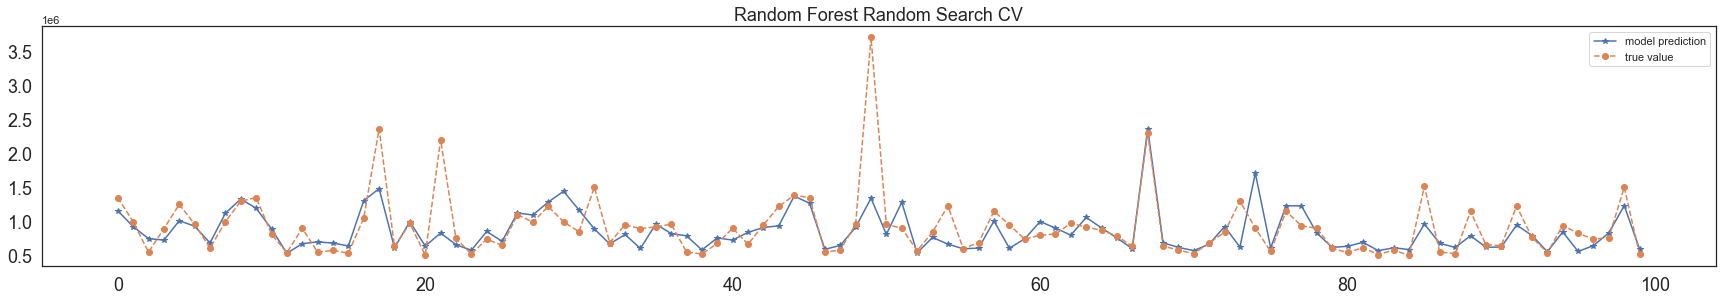

In [24]:
results = wr_pkl_file(file_name = "rfr_test_2.pkl", read = True)
best_estimator = results.best_estimator_
# predictions = best_estimator.predict(x_test)
print_results(["Random Forest Random Search CV"], best_estimator, testing = [tr_x_test, tr_y_test], plt_num = 100)
best_estimator

In [25]:
# ## Grid Search CV
# grid_param = [{"rfregression__n_estimators": [76,77,78],
#                "rfregression__min_samples_leaf":[3]}]


# grid_SCV(pipe = rfrr, grid_param = grid_param, 
#          cv = 10, 
#          scoring = 'neg_mean_squared_error', 
#          file_name = "rfr_grid_test_2.pkl", training = [tr_x_train, tr_y_train])

Random Forest Grid Search CV
R-Squared: 0.660
Root Mean Square Error: 333,572.820
Mean Absolute Error: 187,632.528



{'rfregression__min_samples_leaf': 3, 'rfregression__n_estimators': 77}

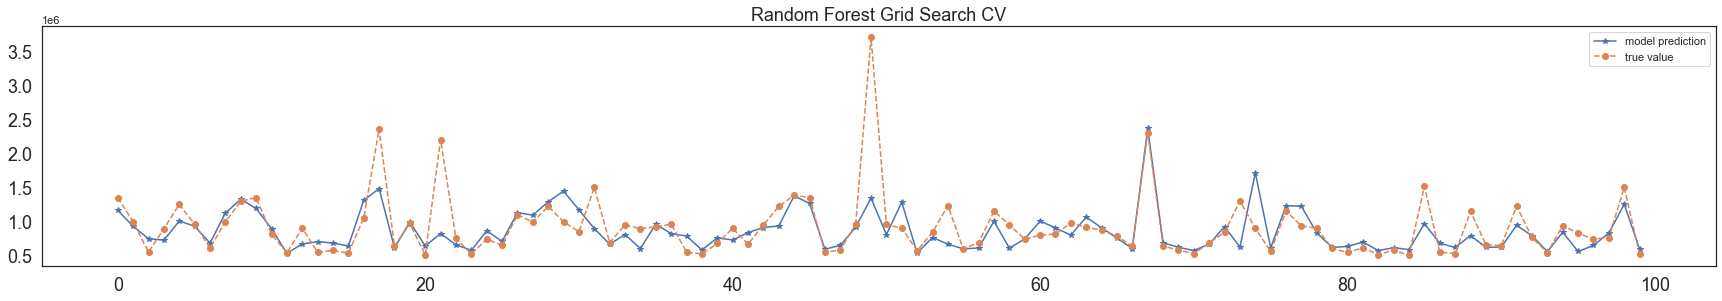

In [32]:
results = wr_pkl_file(file_name = "rfr_grid_test_2.pkl", read = True)
best_estimator = results.best_estimator_
# predictions = best_estimator.predict(x_test)
print_results(["Random Forest Grid Search CV"], best_estimator, testing = [tr_x_test, tr_y_test], plt_num = 100)
results.best_params_